In [ ]:
!nvidia-smi

Mon Oct 31 07:53:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unrar x /content/drive/MyDrive/ImageRetrival/Caltech101ImageDataset.rar

Streaming output truncated to the last 5000 lines.
Extracting  Caltech101/038/4211.jpg                                       52%  OK 
Extracting  Caltech101/038/4212.jpg                                       52%  OK 
Extracting  Caltech101/038/4213.jpg                                       52%  OK 
Extracting  Caltech101/038/4214.jpg                                       52%  OK 
Extracting  Caltech101/038/4215.jpg                                       52%  OK 
Extracting  Caltech101/038/4216.jpg                                       52%  OK 
Extracting  Caltech101/038/4217.jpg                                       52%  OK 
Extracting  Caltech101/038/4218.jpg                                       53%  OK 
Extracting  Caltech101/038/4219.jpg                                       53%  OK 
Extracting  Caltech101/038/4220.jpg                                       53%  OK 
Extracting  Caltech101/038/42

In [ ]:
import numpy as np
from numpy.linalg import norm
  import pickle
  from tqdm import tqdm, tqdm_notebook
  import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model, Sequential

In [ ]:
NUM_CLASSES = 102

In [ ]:
def get_model_optimizer(img_path, model_input):
    img_shape=(224, 224, 3)
    train_datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        zoom_range=0.2)
    train_generator = train_datagen.flow_from_directory(
                    img_path,
                    target_size=(img_shape[0], img_shape[1]),
                    batch_size=32,
                    shuffle=True,
                    seed=12345,
                    class_mode='categorical')
    model = model_input
    inputs = Input(shape=(224, 224, 3))
    x = model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)
    model_similarity_optimized = Model(inputs=inputs, outputs=x)
    model_similarity_optimized.compile(loss='categorical_crossentropy', 
                                          optimizer='adam', 
                                          metrics='accuracy')
    model_similarity_optimized.fit(train_generator, epochs=10)
    model = Sequential(model_similarity_optimized.layers[:-1])
    return model

In [ ]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
                        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img, verbose=0)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [ ]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [ ]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
root_dir = '/content/Caltech101'
filenames = sorted(get_file_list(root_dir))

In [ ]:
model = get_model_optimizer(root_dir, model)

Found 9145 images belonging to 102 classes.
Epoch 1/10
286/286 [==============================] - 151s 475ms/step - loss: 2.4293 - accuracy: 0.4660
Epoch 2/10
286/286 [==============================] - 141s 493ms/step - loss: 1.1529 - accuracy: 0.7009
Epoch 3/10
286/286 [==============================] - 135s 472ms/step - loss: 0.7877 - accuracy: 0.7897
Epoch 4/10
286/286 [==============================] - 138s 481ms/step - loss: 0.5764 - accuracy: 0.8413
Epoch 5/10
286/286 [==============================] - 136s 476ms/step - loss: 0.4472 - accuracy: 0.8700
Epoch 6/10
286/286 [==============================] - 136s 476ms/step - loss: 0.4068 - accuracy: 0.8803
Epoch 7/10
286/286 [==============================] - 137s 477ms/step - loss: 0.3327 - accuracy: 0.9019
Epoch 8/10
286/286 [==============================] - 134s 469ms/step - loss: 0.3042 - accuracy: 0.9102
Epoch 9/10
286/286 [==============================] - 137s 477ms/step - loss: 0.2531 - accuracy: 0.9235
Epoch 10/10
286/286 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.save('/content/drive/MyDrive/ImageRetrival/model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ImageRetrival/model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
 feature_list.append(extract_features(filenames[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/9144 [00:00<?, ?it/s]

In [ ]:
pickle.dump(feature_list, open('/content/drive/MyDrive/ImageRetrival/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('/content/drive/MyDrive/ImageRetrival/filenames-caltech101.pickle','wb'))

In [ ]:
feature_list = pickle.load(open('/content/drive/MyDrive/ImageRetrival/features-caltech101-resnet.pickle', 'rb'))
filenames = pickle.load(open('/content/drive/MyDrive/ImageRetrival/filenames-caltech101.pickle', 'rb'))

In [ ]:
num_feature_dimensions=100
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)

PCA(n_components=100)

In [ ]:
feature_list_compressed = pca.transform(feature_list)

In [ ]:
pickle.dump(pca, open('/content/drive/MyDrive/ImageRetrival/pca.pickle','wb'))

In [ ]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
                              metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

In [ ]:
type(indices)

numpy.ndarray

In [ ]:
indices[0]

array([ 0, 30, 51,  2, 37])

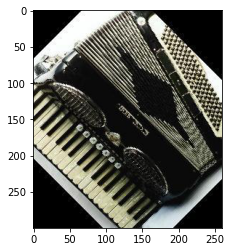

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 # Show the plots as a cell within the Jupyter Notebooks
plt.imshow(mpimg.imread(filenames[0]))

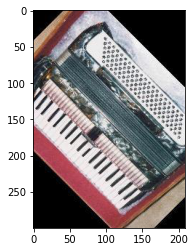

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][3]]))

In [ ]:
import random
num_images = 10

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline # Show the plots as a cell within the Jupyter Notebooks
plt.imshow(mpimg.imread(filenames[0]))

UsageError: unrecognized arguments: # Show the plots as a cell within the Jupyter Notebooks


In [ ]:
distances, indices = neighbors.kneighbors([feature_list[1000]])

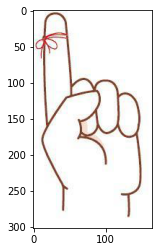

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
 # Show the plots as a cell within the Jupyter Notebooks
plt.imshow(mpimg.imread(filenames[1000]))

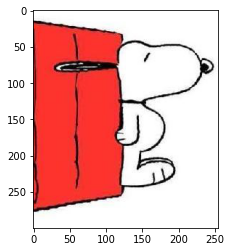

In [ ]:
plt.imshow(mpimg.imread(filenames[indices[0][2]]))

In [ ]:
model_test = load_model('/content/drive/MyDrive/ImageRetrival/model.h5')

In [ ]:
model_test.layers[-3].output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
model_resnet = ResNet50(weights='imagenet', include_top=False,
              input_shape=(224, 224, 3))

In [ ]:
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           